In [1]:
import sys
sys.path.append('/src')

from sfm.DataReader import DataReader
dataReader = DataReader("data/delivery_area_2l/", "", "", ".png")
# dataReader = DataReader("data/pipes/", "dslr_calibration_undistorted", "images/dslr_images_undistorted", ".JPG")

Found 2 images in data/delivery_area_2l/ dataset.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

IMAGES_COUNT = 2
frameL = dataReader.readFrame("{:04d}".format(0), convertToRGB=False, scale=1.0)
frameR = dataReader.readFrame("{:04d}".format(1), convertToRGB=False, scale=1.0)

plt.figure(figsize=(15, 15))
plt.imshow(np.hstack((frameL, frameR)))

In [3]:
import cv2

sift = cv2.xfeatures2d.SIFT_create(nfeatures=200)

keypointsL, descriptorsL = sift.detectAndCompute(frameL, mask=None)
keypointsR, descriptorsR = sift.detectAndCompute(frameR, mask=None)

Number of keypoints detected in each image: 200 200


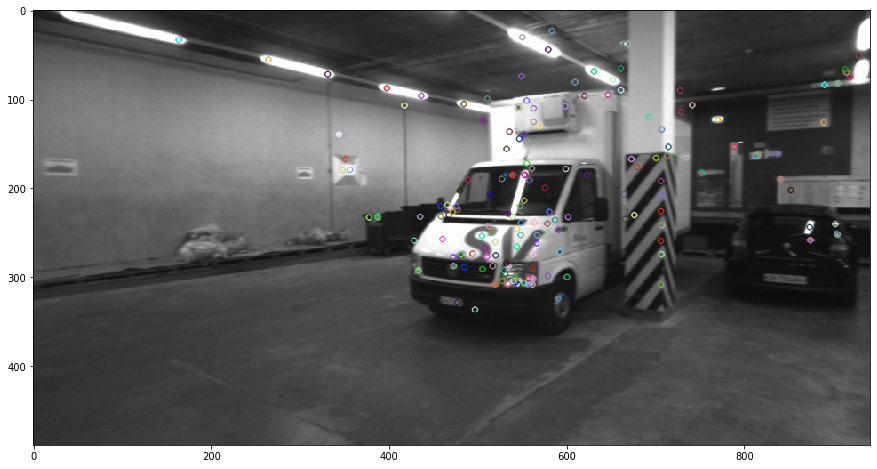

In [4]:
print(f"Number of keypoints detected in each image: {len(keypointsL)} {len(keypointsR)}")
keypointsImage = cv2.drawKeypoints(frameL, keypointsL, None)
plt.figure(figsize=(15, 15))
plt.imshow(keypointsImage)
plt.show()

Found total 163 matches between left and right image (unfiltered).


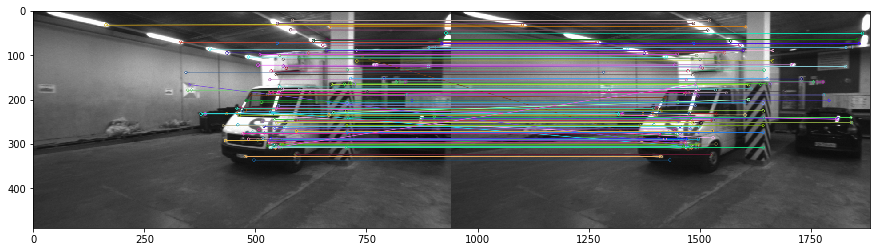

In [5]:
matcher = cv2.BFMatcher(crossCheck=True)
matches = matcher.match(queryDescriptors=descriptorsL, trainDescriptors=descriptorsR)
print(f"Found total {len(matches)} matches between left and right image (unfiltered).")

matchesImage = cv2.drawMatches(frameL, keypointsL, frameR, keypointsR, matches, None, flags=2)
plt.figure(figsize=(15, 15))
plt.imshow(matchesImage)

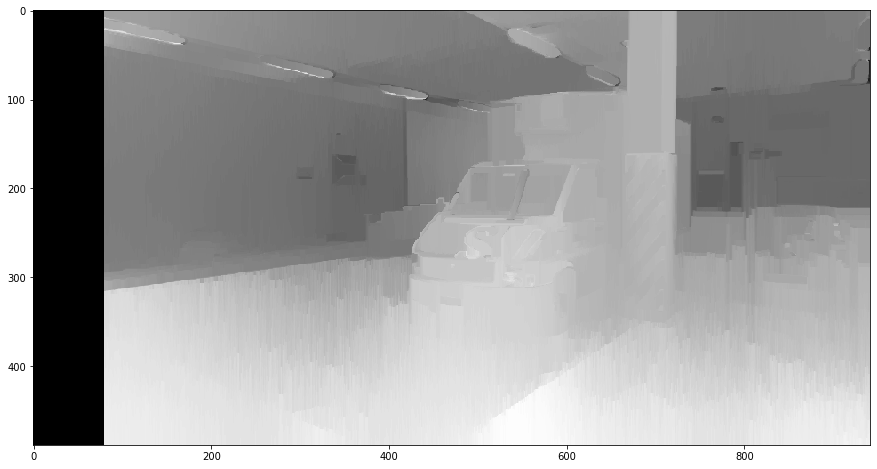

In [7]:
left_matcher = cv2.StereoSGBM_create(numDisparities=80, blockSize=3)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(80000)
wls_filter.setSigmaColor(1.2)

frameGrayL = cv2.cvtColor(frameL, cv2.COLOR_RGB2GRAY)
frameGrayR = cv2.cvtColor(frameR, cv2.COLOR_RGB2GRAY)

dispL = left_matcher.compute(frameGrayL, frameGrayR)
dispR = right_matcher.compute(frameGrayR, frameGrayL)
dispL = np.int16(dispL)
dispR = np.int16(dispR)
disparityMap = wls_filter.filter(dispL, frameGrayL, None, dispR)

disparityMap = cv2.normalize(src=disparityMap, dst=disparityMap, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
disparityMap = np.uint8(disparityMap)

plt.figure(figsize=(15, 15))
plt.imshow(disparityMap, cmap='gray')
plt.show()

In [ ]:
fx, fy = 541.764, 541.764
cx, cy = 553.682, 232.397
baseline = 59.8896
width, height = 942, 489

Q = np.array([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0, fx],
    [0, 0, -1/baseline, 0]
])
print(Q)

In [24]:
image3D = cv2.reprojectImageTo3D(disparityMap, Q, handleMissingValues=True)

pointsColors = []
for y in range(height):
    for x in range(width):
        point3D = image3D[y, x]
        if point3D[2] != 10000:
            color3D = frameL[y, x]
            pointsColors.append((point3D[0], point3D[1], point3D[2], color3D[0], color3D[1], color3D[2]))

print(pointsColors[0])

(178.41904, 87.53562, -204.06306, 69, 69, 69)


In [21]:
import plyfile

def savePointCloud(pointsColors3D, outputFile):
#     vertexes = [ (p[0], p[1], p[2], c[0], c[1], c[2]) for p, c in zip(reprojectedPts, colors3D)]
    # vertexes = [ v for v in vertexes if v[2] >= 0 ] # Discard negative z
    # print(f"\nSample 3D points with colors:\n", vertexes[0])
    dtypes = [('x', 'f8'), ('y', 'f8'), ('z', 'f8'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
    array = np.array(pointsColors3D, dtype=dtypes)
    element = plyfile.PlyElement.describe(array, "vertex")
    plyfile.PlyData([element]).write(outputFile)
    print("Saved point cloud to", outputFile)

savePointCloud(pointsColors, "point_cloud.ply")

Saved point cloud to point_cloud.ply


In [26]:
# %matplotlib notebook
# from pyntcloud import PyntCloud

# point_cloud = PyntCloud.from_file("point_cloud.ply")
# point_cloud.plot()